In [1]:
import networkx as nx; import numpy as np
from random import random, choice
import matplotlib.pyplot as plt
import pandas as pd
import os
from pickle import dump, load
from time import process_time

path = os.getcwd()

In [2]:

def label_BFS(s,K,K_s,T,r,t,a,ext):

    def label_extension(l,arc,dominated):
        for m in range(1):
            i = arc[0]; j = arc[1]
            new_label = [[], 0, 0, 0]

            ''' Check cycle feasibility '''
            if j in l[0]: break

            ''' Check waiting line feasibility '''
            if a[j,s] < l[2]: break
            if a[j,s] > l[3]: new_label[2] = l[2]
            else: new_label[2] = l[3]

            ''' Check time consumption feasibility '''
            #if l[3] > a[j,s] + T: break
            new_label[3] = l[3] + max(0,a[j,s]-l[3]) + t[j,s]
            
            ''' Update the resources consumption '''
            new_label[0] += l[0] + [j]
            new_label[1] = l[1] + r[(i,j)]
            
            if j == "e" and new_label[1] < -0.001:
                done.append(new_label)
            else:
                new_labels[j].append(new_label)
                label_dominance(new_label,j,dominated)
    
    def label_dominance(new_label,j,dominated):
        for l in range(len(labels[j])):
            if set(labels[j][l][0]).issubset(set(new_label[0])):
                dominated[j][l] = True

    ''' Labels list '''
    # Index: number of label
    # 0: route
    # 1: cumulative reduced cost
    # 2: last moment where there was a vehicle waiting in line to use the charger
    # 3: cumulative time consumption
    labels = dict()
    for k in K_s:
        if ("s",k) in ext["s"]: labels[k] = [ [["s",k], r["s",k], a[k,s], a[k,s]+t[k,s]] ]
        else: labels[k] = []
    done = []

    act = 1
    while act > 0:
        
        L = {k:len(labels[k]) for k in K_s}
        new_labels = {k:[] for k in K_s}
        dominated = {k:{l:False for l in range(L[k])} for k in K_s}
        for k in K_s:
            for l in range(L[k]):
                if not dominated[k][l]:
                    for arc in ext[labels[k][l][0][-1]]:
                        label_extension(labels[k][l], arc, dominated)

        labels = new_labels.copy()
        act = sum(len(labels[k]) for k in K_s)
    

    return done

def old_vertices_extensions(V,A):
    
    G = nx.DiGraph()
    G.add_nodes_from(V); G.add_edges_from(A)
    outbound_arcs = {}
    for v in V:
        outbound_arcs[v] = list(G.out_edges(v))
    
    return outbound_arcs

def vertices_extensions(V,A):
    
    G = nx.DiGraph()
    G.add_nodes_from(V); G.add_edges_from(A)
    successors = {}
    for v in V:
        successors[v] = list(G.successors(v))

    return successors

def get_graph(s,K,a,pi,sigma):

    dist = {k:a[k,s] for k in K if pi[k]>0}
    Ks = [k for k in sorted(dist, key=dist.get)]

    V = ["s"] + Ks + ["e"]
    A = [(i,j) for i in V for j in V if i!=j and i!="e" and j!="s" and a[i,s] <= a[j,s] and (i,j)!=("s","e")]

    rc = {arc:-pi[arc[1]]-sigma if arc[0]=="s" else (0 if arc[1]=="e" else -pi[arc[1]]) for arc in A}
    
    return V,A,rc

In [3]:
K = list(range(1,9))


t = {(1, 1): 2.2595473327027493, (2, 1): 0.5200390629643753, (3, 1): 0.4843094235135695, (4, 1): 0.32402349864754265, (5, 1): 0.9771562693923821,
     (6, 1): 2.712259760580588, (7, 1): 2.370289288662281, (8, 1): 1.7461938600324014, ('s', 1): 0, ('e', 1): 0}

a = {(1, 1): 0.6057600423041902, (2, 1): 1.233796350209575, (3, 1): 2.2992334434767896, (4, 1): 2.4732418105509675, (5, 1): 2.4732418105509675,
 (6, 1): 2.9289001244051276, (7, 1): 3.3302139208412322, (8, 1): 5.063481891159141, ('s', 1): 0, ('e', 1): 15}

V,A,rc = get_graph(1,K,a,{k:10 for k in K},0)
ext_BFS = old_vertices_extensions(V,A)
ext_DFS = vertices_extensions(V,A)

In [4]:
def plot_graph(s,a,t,Route=None,complete=False,trial=False):

    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))

    cum_t = 0; i = 1; q = 0
    if not trial:
        for k in Route:
            if complete:
                if cum_t > a[k,s]: ax.barh(y=i,width=cum_t-a[k,s],height=1,left=a[k,s],color="lemonchiffon")
                ax.barh(y=i,width=t[k,s],height=1,left=max(cum_t,a[k,s]),color="gold")
            else:
                if a[k,s] < q:
                    ax.barh(y=i,width=cum_t-a[k,s],height=1,left=a[k,s],color="lightsalmon")
                    ax.barh(y=i,width=t[k,s],height=1,left=max(cum_t,a[k,s]),color="crimson")
                else:
                    if cum_t > a[k,s]: ax.barh(y=i,width=cum_t-a[k,s],height=1,left=a[k,s],color="turquoise")
                    ax.barh(y=i,width=t[k,s],height=1,left=max(cum_t,a[k,s]),color="forestgreen")
            if a[k,s] <= cum_t: q = cum_t
            cum_t += max(0,a[k,s]-cum_t) + t[k,s]; i+=1
    else:
        for k in Route:
            
            if k == Route[-1]: col1 = "pink"; col2 = "deeppink"
            elif complete: col1 = "lemonchiffon"; col2 = "gold"
            elif a[k,s] < q: col1 = "lightsalmon"; col2 = "crimson"
            else: col1 = "turquoise"; col2 = "forestgreen"

            if complete:
                if cum_t > a[k,s]: ax.barh(y=i,width=cum_t-a[k,s],height=1,left=a[k,s],color=col1)
                ax.barh(y=i,width=t[k,s],height=1,left=max(cum_t,a[k,s]),color=col2)
            else:
                if a[k,s] < q:
                    ax.barh(y=i,width=cum_t-a[k,s],height=1,left=a[k,s],color=col1)
                    ax.barh(y=i,width=t[k,s],height=1,left=max(cum_t,a[k,s]),color=col2)
                else:
                    if cum_t > a[k,s]: ax.barh(y=i,width=cum_t-a[k,s],height=1,left=a[k,s],color=col1)
                    ax.barh(y=i,width=t[k,s],height=1,left=max(cum_t,a[k,s]),color=col2)
            if a[k,s] <= cum_t: q = cum_t
            cum_t += max(0,a[k,s]-cum_t) + t[k,s]; i+=1
        

    ax.set_xlim(0,9)
    ax.set_ylim(0.5,5.5)

    timesteps = [t*9/10 for t in range(11)]
    ax.set_xticks(timesteps); ax.set_xticklabels([int(t*60) for t in timesteps],fontsize=14)
    

    if len(Route) == 0: ax.set_yticks([1]), ax.set_yticklabels(["k0"],fontsize=14); ax.tick_params(axis="y", colors="white")
    else: ax.set_yticks([k for k in range(1,i)]); ax.set_yticklabels([f"k{k}" for k in Route],fontsize=14)
    

    if complete: col1 = "lemonchiffon"; col2 = "gold"
    else: col1 = "turquoise"; col2 = "forestgreen"
    ax.bar(x=0,height=0,color=col1,label="Waiting"); ax.bar(x=0,height=0,color=col2,label="Charging")
    leg = ax.legend(loc="upper right",ncol=2)

    for text in leg.get_texts():
        text.set_fontfamily("Century Gothic")

    ax.set_xlabel("Time (minutes)",fontsize=14,fontname="Century Gothic")
    ax.set_ylabel("Vehicles",fontsize=14,fontname="Century Gothic")

    for tick in ax.get_xticklabels():
        tick.set_fontname("Cambria")
    for tick in ax.get_yticklabels():
        tick.set_fontname("Cambria")

    ax.invert_yaxis()

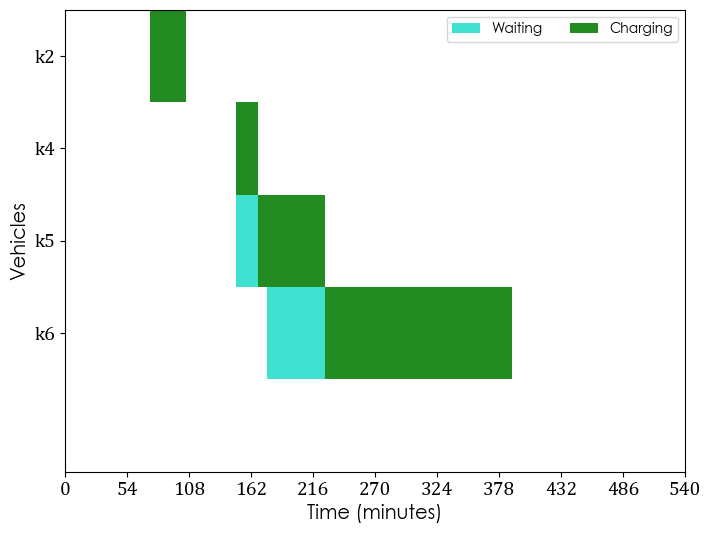

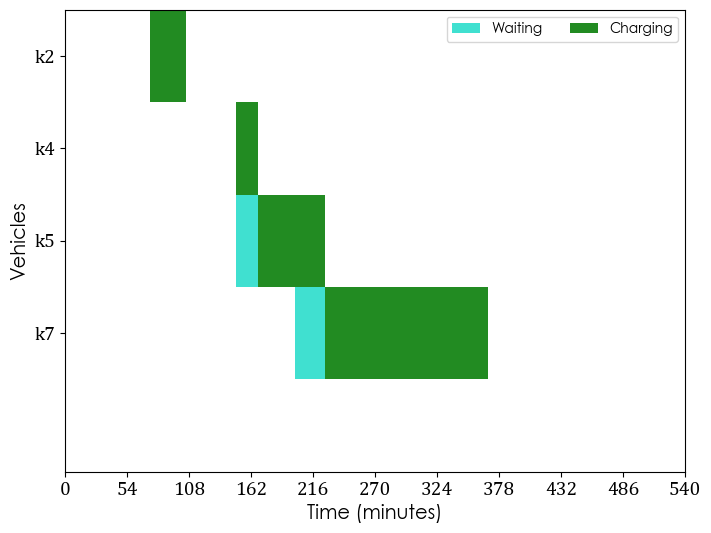

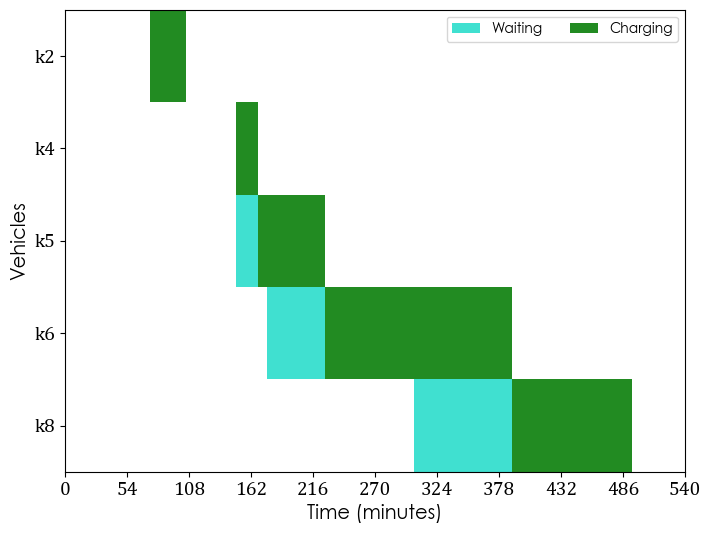

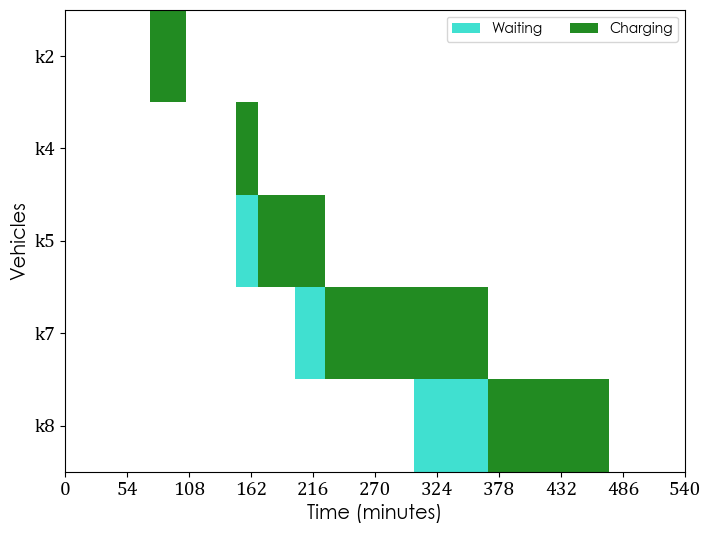

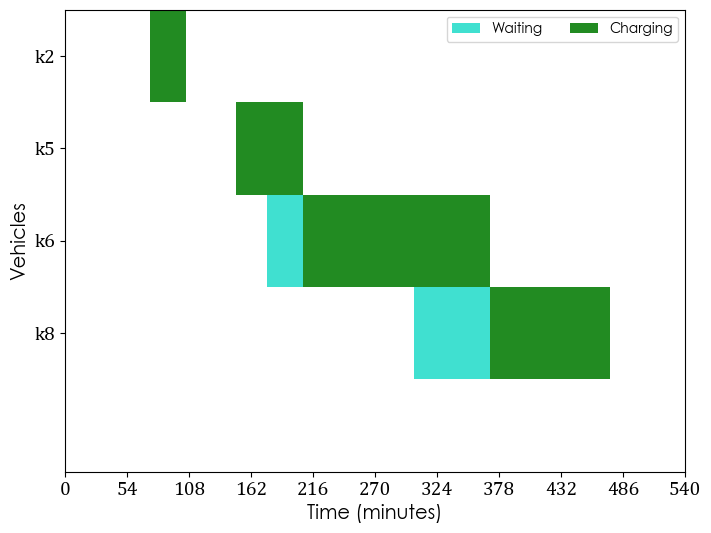

In [18]:
routes = [[2,4,5,6],[2,4,5,7],[2,4,5,6,8],[2,4,5,7,8],[2,5,6,8]]
for route in routes:
    plot_graph(1,a,t,route)

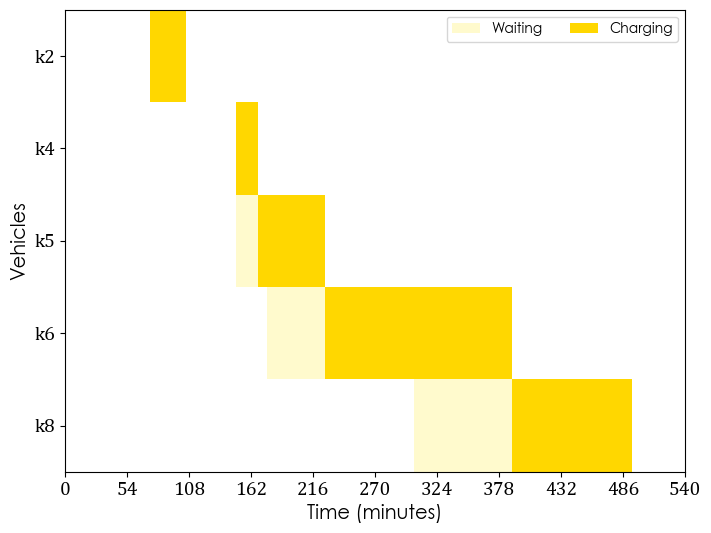

In [19]:
routes = [[2,4,5,6,8]]
for route in routes:
    plot_graph(1,a,t,route,complete=True)

In [18]:
def check_dominance(path,routes):
        dom = False
        for i in range(len(routes)-1,-1,-1):
            if set(path).issubset(routes[i]):
                dom = True; break
        if not dom: routes.append(path)

def label_DFS(v,rP,tP,qP,P,cK,L,s,r,t,a,ext):
    for m in range(1):
        
        if len(cK) > 0 and (P[-1] in cK or (P[-1]=="s" and v in cK)): break
        
        if v in P: break
        if a[v,s] < qP: break

        nP = P + [v]
        if v == "e":
            cK.update(nP[1:-1])
            if rP < -0.001:
                L.append(P[1:])

        if a[v,s] == tP - t[v,s]: nqP = qP
        else: nqP = tP - t[v,s]

        for v1 in ext[v]:
            ntP = np.max((tP,a[v1,s])) + t[v1,s]
            nrP = rP + r[v,v1]
            label_DFS(v1,nrP,ntP,nqP,nP,cK,L,s,r,t,a,ext)

def new_label_DFS(v,rP,tP,qP,P,cK,L,s,r,t,a,ext):
    for m in range(1):
        
        if len(cK) > 0 and (P[-1] in cK or (P[-1]=="s" and v in cK)): break
        
        if v in P: break
        if a[v,s] < qP: break

        if v == "e":
            cK.update(P[1:])
            if rP < -0.001:
                L.append(P[1:])
            break
        nP = P + [v]

        if a[v,s] == tP - t[v,s]: nqP = qP
        else: nqP = tP - t[v,s]

        nodes = ext[v][:-1]
        fin_times = np.array([np.max((tP,a[i,s]))+t[i,s] for i in nodes])
        sorted_indices = np.argsort(fin_times)
        sort_array = np.array(nodes)[sorted_indices].tolist()
        for v1 in sort_array:
            ntP = np.max((tP,a[v1,s])) + t[v1,s]
            nrP = rP + r[v,v1]
            new_label_DFS(v1,nrP,ntP,nqP,nP,cK,L,s,r,t,a,ext)
        new_label_DFS("e",rP,tP,nqP,nP,cK,L,s,r,t,a,ext)

def label_DFS_exhaustive(v,rP,tP,qP,P,L,s,r,t,a,ext):
    for m in range(1):

        if v in P: break
        if a[v,s] < qP: break

        nP = P + [v]
        if v == "e" and rP<-0.001:
            check_dominance(P[1:],L)

        if a[v,s] == tP - t[v,s]: nqP = qP
        else: nqP = tP - t[v,s]

        for v1 in ext[v]:
            ntP = np.max((tP,a[v1,s])) + t[v1,s]
            nrP = rP + r[v,v1]
            label_DFS_exhaustive(v1,nrP,ntP,nqP,nP,L,s,r,t,a,ext)

def update_best_routes(L,P,rP,tP,hP,best_len,best_t,best_h,num_improv):
    L[P[0]] = (P,rP)
    best_len[P[0]] = len(P)
    best_t[P[0]] = tP
    best_h[P[0]] = hP
    num_improv[P[0]] += 1
    #print(f"\tImprov {P[0]}: {num_improv[P[0]]}, best_len = {best_len[P[0]]}")

def check_end_dominance(L,P,rP,tP,hP,best_len,best_t,best_h,num_improv,tried):
    for m in range(1):
        #print(P)
        if len(P) < best_len[P[0]]:
            tried[P[0]] += 1
            break
        elif len(P) > best_len[P[0]]:
            update_best_routes(L,P,rP,tP,hP,best_len,best_t,best_h,num_improv)
            break
        else:
            if tP < best_t[P[0]]:
                tried[P[0]] += 1
                break
            elif tP > best_t[P[0]]:
                update_best_routes(L,P,rP,tP,hP,best_len,best_t,best_h,num_improv)
                break
            else:
                if hP > best_h[P[0]]:
                    tried[P[0]] += 1
                    break
                else:
                    update_best_routes(L,P,rP,tP,hP,best_len,best_t,best_h,num_improv)
                    break

def update_max_succesors(P, marked, max_successors):
    for k in marked:
                if marked[k]:
                    ix = P.index(k)
                    if max_successors[k] == 100: max_successors[k] = len(P[ix:])
                    else:
                        max_successors[k] = np.max(( max_successors[k], len(P[ix:]) ))

def sort_extensions(v,s,tP,ext,a,t):

    if v == "s": nodes = ext
    else: nodes = ext[:-1]
    fin_times = np.array([np.max((tP,a[i,s]))+t[i,s] for i in nodes])
    sorted_indices = np.argsort(fin_times)
    sort_array = np.array(nodes)[sorted_indices].tolist()
    if v != "s": sort_array.append("e")

    return sort_array

def mod_label_DFS(v,rP,tP,qP,hP,P,cK,L,s,r,t,a,ext,best_len,best_t,best_h,num_improv,tried,marked,max_successors):
    for m in range(1):
        
        if len(P) > 1 and v!="e":
            if len(P[1:]) + max_successors[v] < best_len[P[1]]: break
            if num_improv[P[1]] > 3 or tried[P[1]] > 1000: break
        
        if cK[v]: break
        if len(P) == 1:
            li = np.concatenate([L[kk][0] for kk in L])
            cK.update({k:1 if k in li else 0 for k in cK})
            for k in cK:
                if cK[k] == 0: max_successors[k] = 100
            if cK[v]: break

        if v in P: break
        if a[v,s] < qP: break

        if v == "e":
            update_max_succesors(P, marked, max_successors)
            check_end_dominance(L,P[1:],rP,tP,hP,best_len,best_t,best_h,num_improv,tried)
            break
        nP = P + [v]

        if a[v,s] == tP - t[v,s]:
            nqP = qP
            if v != "s": marked[v] = 1
        else: nqP = tP - t[v,s]

        sort_ext = sort_extensions(v,s,tP,ext[v],a,t)
        print(f"sorted extensions from node {v}: {sort_ext}")
        for v1 in sort_ext:
            start_v1 = np.max((tP,a[v1,s]))
            nhP = hP + start_v1 - tP
            ntP = start_v1 + t[v1,s]
            nrP = rP + r[v,v1]
            mod_label_DFS(v1,nrP,ntP,nqP,nhP,nP,cK,L,s,r,t,a,ext,best_len,best_t,best_h,num_improv,tried,marked,max_successors)
        marked[v] = 0

        

In [84]:
K = list(range(1,9))


t = {(1, 1): 2.2595473327027493, (2, 1): 0.5200390629643753, (3, 1): 0.4843094235135695, (4, 1): 0.32402349864754265, (5, 1): 0.9771562693923821,
     (6, 1): 2.712259760580588, (7, 1): 2.370289288662281, (8, 1): 1.7461938600324014, ('s', 1): 0, ('e', 1): 0}

a = {(1, 1): 0.6057600423041902, (2, 1): 1.233796350209575, (3, 1): 2.2992334434767896, (4, 1): 2.4732418105509675, (5, 1): 2.4732418105509675,
 (6, 1): 2.9289001244051276, (7, 1): 3.3302139208412322, (8, 1): 5.063481891159141, ('s', 1): 0, ('e', 1): 15}

V,A,rc = get_graph(1,K,a,{k:10 for k in K},0)
ext_BFS = old_vertices_extensions(V,A)
ext_DFS = vertices_extensions(V,A)

In [5]:
K = list(range(1,2))
T = 4
a = {(k,1):0.5+random()*2+2*choice([0,1,2]) for k in K}
t = {(k,1):0.3+random()*2.5 for k in K}
a.update({("s",1):0,("e",1):15})
t.update({("s",1):0,("e",1):0})
V,A,rc = get_graph(1,K,a,{k:10 for k in K},0)
ext_BFS = old_vertices_extensions(V,A)
ext_DFS = vertices_extensions(V,A)

In [19]:
routes_DFS = []
covered_nodes_DFS = set(); time0=process_time()
new_label_DFS(v="s",rP=0,tP=0,qP=0,P=[],cK=covered_nodes_DFS,L=routes_DFS,s=1,r=rc,t=t,a=a,ext=ext_DFS)
round(process_time()-time0,15), routes_DFS

(0.0, [])

In [12]:

ext_DFS

{'s': [1], 1: ['e'], 'e': []}

In [20]:
routes_mod = {"s":[0]}; marked = {}; max_successors = {v:100 for v in V}; tried = {v:0 for v in V}
mod_covered_nodes = {v:0 for v in V} ; time0 = process_time(); best_len = {v:0 for v in V}; best_t = {v:0 for v in V}; best_h = {v:30 for v in V}; num_improv = {v:0 for v in V}
mod_label_DFS(v="s",rP=0,tP=0,qP=0,hP=0,P=[],cK=mod_covered_nodes,L=routes_mod,s=1,r=rc,t=t,a=a,ext=ext_DFS,best_len=best_len,best_t=best_t,best_h=best_h,num_improv=num_improv,tried=tried,marked=marked,max_successors=max_successors)
round(process_time()-time0,15), len(routes_mod), routes_mod

TypeError: list indices must be integers or slices, not str

In [27]:
marked

{'s': 0,
 46: 0,
 44: 0,
 41: 0,
 39: 0,
 4: 0,
 24: 0,
 21: 0,
 17: 0,
 19: 0,
 26: 0,
 43: 0,
 45: 0,
 15: 0,
 37: 0,
 25: 0,
 10: 0,
 14: 0,
 1: 0,
 38: 0,
 49: 0,
 22: 0,
 20: 0,
 6: 0,
 32: 0,
 34: 0,
 2: 0,
 13: 0,
 31: 0,
 35: 0,
 9: 0,
 50: 0,
 8: 0,
 42: 0,
 11: 0,
 30: 0,
 33: 0,
 7: 0,
 28: 0,
 18: 0,
 23: 0,
 16: 0,
 27: 0,
 36: 0,
 3: 0,
 12: 0,
 29: 0,
 47: 0,
 40: 0,
 48: 0,
 5: 0,
 'e': 0}

In [ ]:

a = {(k,1):0.5+random()*2+2*choice([0,1,2]) for k in K}
t = {(k,1):0.3+random()*2.5 for k in K}
a.update({("s",1):0,("e",1):15})
t.update({("s",1):0,("e",1):0})
V,A,rc = get_graph(1,K,a,{k:10 for k in K},0)
ext_BFS = old_vertices_extensions(V,A)
ext_DFS = vertices_extensions(V,A)

In [103]:
Li = {'s': ['s'], 46: [46, 49, 17, 23, 26, 16, 21, 45, 47, 44, 4]}
aa = np.concatenate(list(Li.values())).tolist()

In [13]:
aa = {}
aa.values()

dict_values([])

In [53]:
routes_DFS_exhaustive = []; time0 = process_time()
label_DFS_exhaustive(v="s",rP=0,tP=0,qP=0,P=[],L=routes_DFS_exhaustive,s=1,r=rc,t=t,a=a,ext=ext_DFS)
round(process_time()-time0,15), len(routes_DFS_exhaustive), routes_DFS_exhaustive

(20.59375,
 5010,
 [[12, 14, 11, 15, 18, 16],
  [12, 14, 11, 15, 18, 4],
  [12, 14, 11, 15, 18, 13],
  [12, 14, 11, 15, 18, 20],
  [12, 14, 11, 15, 23, 16],
  [12, 14, 11, 15, 23, 4],
  [12, 14, 11, 15, 23, 13],
  [12, 14, 11, 15, 23, 20],
  [12, 14, 11, 15, 6, 16, 13],
  [12, 14, 11, 15, 6, 16, 20],
  [12, 14, 11, 15, 6, 4, 13],
  [12, 14, 11, 15, 6, 4, 20],
  [12, 14, 11, 15, 6, 13, 20],
  [12, 14, 11, 15, 1, 16, 20],
  [12, 14, 11, 15, 1, 4, 20],
  [12, 14, 11, 15, 1, 13, 20],
  [12, 14, 11, 15, 21, 16, 4],
  [12, 14, 11, 15, 21, 16, 13],
  [12, 14, 11, 15, 21, 16, 20],
  [12, 14, 11, 15, 21, 4, 13],
  [12, 14, 11, 15, 21, 4, 20],
  [12, 14, 11, 15, 21, 13, 20],
  [12, 14, 11, 15, 7, 16],
  [12, 14, 11, 15, 7, 4],
  [12, 14, 11, 15, 7, 13],
  [12, 14, 11, 15, 7, 20],
  [12, 14, 11, 5, 18, 21],
  [12, 14, 11, 5, 18, 7],
  [12, 14, 11, 5, 18, 16],
  [12, 14, 11, 5, 18, 4],
  [12, 14, 11, 5, 18, 13],
  [12, 14, 11, 5, 18, 20],
  [12, 14, 11, 5, 23, 21],
  [12, 14, 11, 5, 23, 7],
  [12,

In [15]:
cd = 0.041
cw = 0.0388


K = list(range(1,9))

a = [0.5+random()*2+2*choice([0,1,2]) for k in K[:-1]]
a = sorted(a)
a = a + [a[3]]
a = sorted(a)

T = 4
a = {(k,1):a[k-1] for k in K}
t = {(k,1):0.3+random()*2.5 for k in K}
a.update({("s",1):0,("e",1):15})
t.update({("s",1):0,("e",1):0})
V,A,rc = get_graph(1,K,a,{k:10 for k in K},0)
ext_DFS = vertices_extensions(V,A)




In [16]:
dem_dist = pd.read_excel(path+"/Demand distribution.xlsx")

C:\Users\ari_r\AppData\Local\Temp\ipykernel_26360\4160648603.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=14,fontname="Cambria")


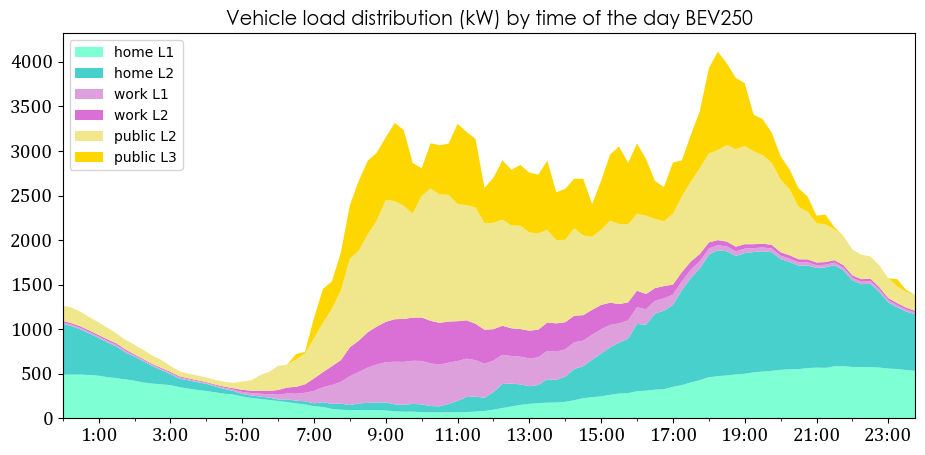

In [35]:
fig, ax = plt.subplots(figsize=(11,5))

labels = ["home L1", "home L2", "work L1", "work L2", "public L2", "public L3"]
cols = ["aquamarine","mediumturquoise","plum","orchid","khaki","gold"]

ax.stackplot(dem_dist.index,dem_dist["home_l1"],dem_dist["home_l2"],dem_dist["work_l1"],dem_dist["work_l1"],dem_dist["public_l2"],dem_dist["public_l3"],labels=labels,colors=cols)
ax.set_xlim(0,95)
ax.set_title("Vehicle load distribution (kW) by time of the day BEV250",fontsize=14,fontname="Century Gothic")

ax.set_xticks([i for i in range(0,96,8)],minor=True)
ax.set_xticks([i for i in range(4,96,8)])
ax.set_xticklabels(["{}:00".format(int(i/4)) for i in range(4,96,8)],fontsize=14,fontname="Cambria")
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14,fontname="Cambria")

ax.legend(loc="upper left")

C:\Users\ari_r\AppData\Local\Temp\ipykernel_26360\2667162987.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=14,fontname="Cambria")


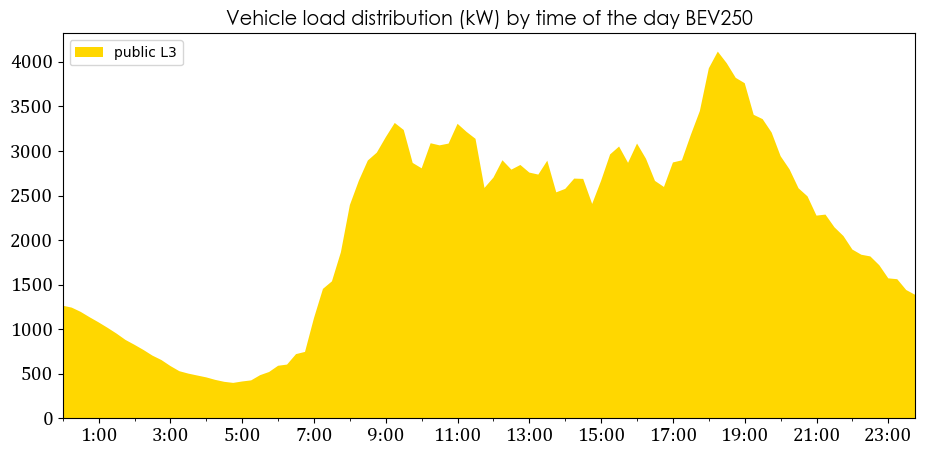

In [36]:
fig, ax = plt.subplots(figsize=(11,5))

labels = ["public L3"]
cols = ["gold"]

total = dem_dist["home_l1"]+dem_dist["home_l2"]+dem_dist["work_l1"]+dem_dist["work_l1"]+dem_dist["public_l2"]+dem_dist["public_l3"]

ax.stackplot(dem_dist.index,total,labels=labels,colors=cols)
ax.set_xlim(0,95)
ax.set_title("Vehicle load distribution (kW) by time of the day BEV250",fontsize=14,fontname="Century Gothic")

ax.set_xticks([i for i in range(0,96,8)],minor=True)
ax.set_xticks([i for i in range(4,96,8)])
ax.set_xticklabels(["{}:00".format(int(i/4)) for i in range(4,96,8)],fontsize=14,fontname="Cambria")
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14,fontname="Cambria")

ax.legend(loc="upper left")

In [4]:
energy_bps = [0,212.5,237.5,250] # Energy level (miles) breakpoints in the piecewise linear function
time_bps = [1.5,1.887096774,2.467741935]

charging_rates = [141.6666667,64.58333333,21.52777778] # Charging rates (miles/hour) for every piece in the charging function
full_rch_time = 2.467741935

In [5]:
def charg_function(t):

    if t <= time_bps[0]: en = charging_rates[0]*t
    elif t <= time_bps[1]: en = charging_rates[0]*time_bps[0]+charging_rates[1]*(t-time_bps[0])
    else: en = charging_rates[0]*time_bps[0]+charging_rates[1]*(time_bps[1]-time_bps[0])+charging_rates[2]*(t-time_bps[1])

    return en

charg = []
for t in range(0,246):
    charg.append(charg_function(t/100))

(-10.0, 260.0)

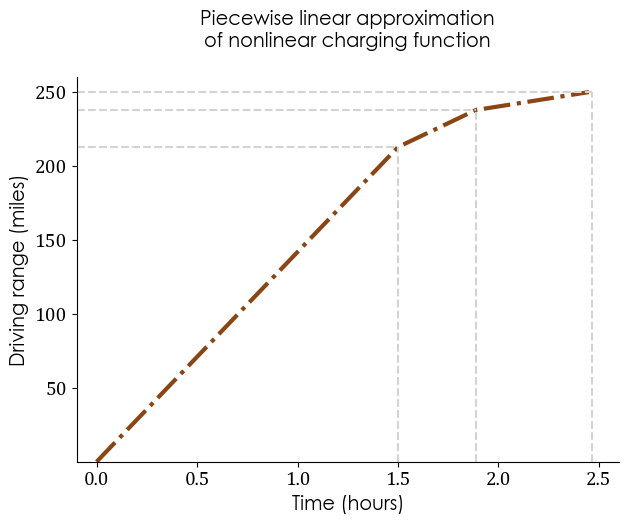

In [7]:
fig, ax = plt.subplots(figsize=(7,5))

ax.plot(charg,linewidth=3,color="saddlebrown",linestyle="dashdot")
ax.vlines(x=[i*100 for i in time_bps],ymin=0,ymax=[charg_function(i) for i in time_bps],linestyle="--",color="lightgray")
ax.hlines(y=[i for i in energy_bps[1:]],xmin=-10,xmax=[i*100 for i in time_bps],linestyle="--",color="lightgray")

ax.set_title("Piecewise linear approximation\nof nonlinear charging function\n",fontsize=14,fontname="Century Gothic")
ticks = [i for i in range(0,251,50)]
ax.set_xticks(ticks); ax.set_xticklabels([round(i/100,1) for i in ticks],fontsize=14,fontname="Cambria")
ticks = [i for i in range(50,251,50)]
ax.set_yticks(ticks); ax.set_yticklabels(ax.get_yticklabels(),fontsize=14,fontname="Cambria")

ax.set_ylabel("Driving range (miles)",fontsize=14,fontname="Century Gothic")
ax.set_xlabel("Time (hours)",fontsize=14,fontname="Century Gothic")

ax.spines[["top","right"]].set_visible(False)

ax.set_ylim(0,260)
ax.set_xlim(-10,260)

(-10.0, 260.0)

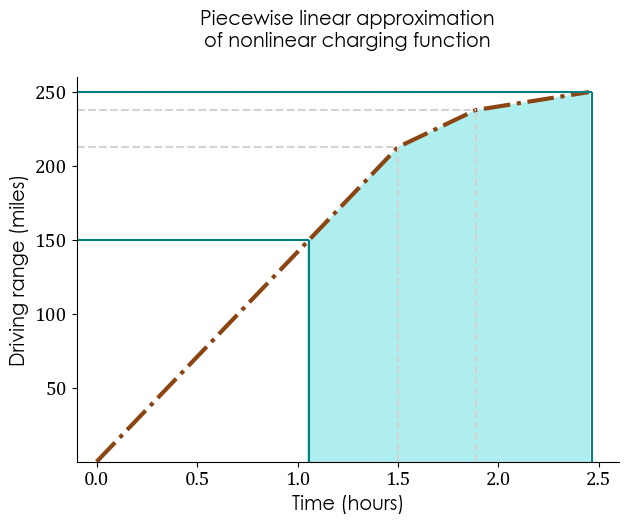

In [15]:
fig, ax = plt.subplots(figsize=(7,5))

ax.plot(charg,linewidth=3,color="saddlebrown",linestyle="dashdot")
ax.vlines(x=[i*100 for i in time_bps],ymin=0,ymax=[charg_function(i) for i in time_bps],linestyle="--",color="lightgray")
ax.hlines(y=[i for i in energy_bps[1:]],xmin=-10,xmax=[i*100 for i in time_bps],linestyle="--",color="lightgray")

time_150 = 150/charging_rates[0]
recharge = []
for i in range(int(time_150*100),246):
    recharge.append(charg_function(i/100))

ax.fill_between(x=range(int(time_150*100),246),y1=0,y2=recharge,color="paleturquoise")
ax.hlines(y=[150,250],xmin=-10,xmax=[time_150*100,time_bps[-1]*100],color="teal")
ax.vlines(x=[time_150*100,time_bps[-1]*100],ymin=0,ymax=[charg_function(time_150), charg_function(time_bps[-1])], color = "teal")


ax.set_title("Piecewise linear approximation\nof nonlinear charging function\n",fontsize=14,fontname="Century Gothic")
ticks = [i for i in range(0,251,50)]
ax.set_xticks(ticks); ax.set_xticklabels([round(i/100,1) for i in ticks],fontsize=14,fontname="Cambria")
ticks = [i for i in range(50,251,50)]
ax.set_yticks(ticks); ax.set_yticklabels(ax.get_yticklabels(),fontsize=14,fontname="Cambria")

ax.set_ylabel("Driving range (miles)",fontsize=14,fontname="Century Gothic")
ax.set_xlabel("Time (hours)",fontsize=14,fontname="Century Gothic")

ax.spines[["top","right"]].set_visible(False)

ax.set_ylim(0,260)
ax.set_xlim(-10,260)